## Capstone Project: Bank Sales Excellence - Exploratory Data Analysis ##

**Problem Statement:** A digital arm of a bank faces challenges with lead conversions. The primary objective of this department is to increase customer acquisition through digital channels. The department was setup a few years back and the primary focus of the department over these yeas has been to increase number of leads getting into the conversion funnel.

They source leads through channels like search, display, emali campaigns and via affiliate partners. As expected, they see differential conversion dependings on the sources and the quality of these leads.

They now like to identify the leads' segments that have a higher conversion ratio (lead to buying a product) so they can specifically target these potential customers through additional channels and re-marketing. They have provided a partial dataset for salaried customers from the last 3 months. They also captured basic demographics about their customers. We need to identify the segment of customers with a high probability of conversion in the next 30 days. 

**Stakeholders:** 
* Bank account managers
* Digital marketing analysts
* Customer sales representatives

## Part A. Import Cleaned Dataset ##

In [1]:
# Import all libraries #
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import csv
from sklearn.utils import shuffle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Authorization #
__author__ = "Taesun Yoo"
__email__ = "yoots1988@gmail.com"

In [2]:
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def convert_dt_as_date(df, var_name, date_format):
    '''convert the variable as specified date format'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)
    return df[var_name]


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_to_cat(df):
    '''convert data type to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')


def eda_encode_cat_var(df, col, num_var):
    '''encode the cat. variables by mean of a num. variable by each cat'''
    cat_dict={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat][num_var].mean()
    df[col] = df[col].map(cat_dict)

    
def encode_categorical_feature(df, var_name, map_name):
    '''encode categorical features into mapping values'''
    df[var_name] = df[var_name].map(map_name)
    return df[var_name]


def convert_DOB_to_age(df, var_name, date_format):
    '''set DOB as datetime and calculate age'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)
    df[var_name] = np.where(df[var_name] > datetime.now(),
                            df[var_name] - timedelta(365*100),
                            df[var_name])
    df['age'] = datetime.now().year - df[var_name].apply(lambda x:x.year)

def feature_replacement(X):
    ''' replace missing values based on specific data type of a column '''
    for col in X.columns:
        if X[col].dtype.name == 'object':
            mode = X[col].mode().iloc[0]
            X[col] = X[col].fillna(mode)
        elif X[col].dtype.name == 'float64':
            mean = X[col].mean()
            X[col] = X[col].fillna(mean)
        else:
            X[col].dtype.name == 'int64'
            median = X[col].median()
            X[col] = X[col].fillna(median)
            

def eda_missing(df):
    '''compute missing % on each var'''
    df_missing = pd.DataFrame(df.isnull().sum(), columns=['count'])
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def eda_stat_num(df):
    ''' perform eda for numerical features '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', 'std', '25%', '50%', '75%']]
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def eda_stat_cat(df):
    ''' perform eda for categorical features '''
    df_stat_cat = df.describe(include='category').T
    df_stat_cat = pd.DataFrame(df_stat_cat)
    return df_stat_cat


def eda_outliers(df):
    '''check outliers using the IQR method'''
    df['IQR'] = df['75%'] - df['25%']
    df['LB']  = df['25%'] - 1.5*df['IQR']
    df['UB']  = df['75%'] + 1.5*df['IQR']
    df = df.drop(['count','std','mean','25%','50%','75%','IQR'], axis=1)
    return df


def eda_agg_df_var(df, cat_var, kpi_dict):
    '''compute aggregated dataframe to calculate the KPIs'''
    df_agg = df.groupby(by=cat_var).agg(kpi_dict)
    return df_agg


def eda_grouped_df_var(df, cat_var):
    '''create a grouped dataframe by categorical variable'''
    df_grp = pd.DataFrame(df.groupby([cat_var])[cat_var].count())
    df_grp.columns = ['count']
    return df_grp


def plot_hist(df, var_1):
    '''plot a histogram'''
    plt.figure()
    print("skenewss is:", df[var_1].skew())
    df[var_1].hist(color='green')
    plt.title('Histogram of ' + var_1)
    plt.xlabel(var_1)
    plt.ylabel('clients')
    plt.show()


def plot_bar_chart(df, var_name_1):
    '''plot a bar chart'''
    plt.figure()
    var_count_1 = df[var_name_1].value_counts()
    sns.barplot(var_count_1.index,  var_count_1.values, alpha=0.9)
    plt.title('Frequency chart of ' + var_name_1)
    plt.ylabel('clients')
    plt.xlabel(var_name_1)
    plt.show()

    
def plot_freq_chart(x,y,df,order):
    '''plot a frequency chart'''
    plt.figure(figsize=(8,8))
    sns.countplot(x=x, hue=y, data=df, order=order)
    plt.title('Bar chart: ' + x + ' of approved status labels', fontsize=20)
    plt.xticks(rotation=270, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('clients', fontsize=12)
    plt.legend(loc='upper right', fontsize=20)
    plt.show()


def plot_pie_chart(df_1, var_name_1,
                   df_2, var_name_2):
    '''plot a pie chart of specified variables'''
    plt.figure(figsize=(15,15))
    # Sub-plot 1:
    plt.subplot(1,2,1)
    plt.pie(df_1, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_1)
    plt.legend(labels = df_1.index, loc='upper right')
    # Sub-plot 2:
    plt.subplot(1,2,2)
    plt.pie(df_2, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_2)
    plt.legend(labels = df_2.index, loc='upper right')
    plt.show()
    

def plot_box(df, num_var_1, cat_var_1,
             num_var_2, cat_var_2, 
             num_var_3, cat_var_3, hue=None):
    '''plot a box-whisker of specified variables'''
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # Sub-plot 1:
    plt.subplot(1,3,1)
    df.sort_values(by=[num_var_1], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_1, num_var_1, hue, df)
    plt.title('Box plot of ' + num_var_1 + ' by ' + cat_var_1)
    plt.xticks(rotation=270, fontsize=10)
    # Sub-plot 2:
    plt.subplot(1,3,2)
    df.sort_values(by=[num_var_2], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_2, num_var_2, hue, df)
    plt.title('Box plot of ' + num_var_2 + ' by ' + cat_var_2)
    plt.xticks(rotation=270, fontsize=10)
    # Sub-plot 3:
    plt.subplot(1,3,3)
    df.sort_values(by=[num_var_3], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_3, num_var_3, hue, df)
    plt.title('Box plot of ' + num_var_3 + ' by ' + cat_var_3)
    plt.xticks(rotation=270, fontsize=10)    

    
def plot_crosstab(df, cat_var_1, cat_var_2):
    '''plot a crosstab of two categorical variables'''
    table = pd.crosstab(df[cat_var_1], df[cat_var_2])
    return table


def plot_corr_matrix(df, list_vars):
    ''' plot a correlation matrix '''
    corr = df[list_vars].corr()
    # Create a mask
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, mask=mask, square=True, linewidths = .5,
                cmap=sns.diverging_palette(220,10,as_cmap=True),
                vmin = -1, vmax = 1, fmt=".2f",
                annot=True, annot_kws={'size':15})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


def plot_scatter(df, var_1, var_2, color, factor=None):
    '''Scatter plot of two continuous numeric features'''
    plt.figure(figsize=(8,8))
    plt.scatter(df[var_1], df[var_2], color=color)
    plt.title('Relationship between '+ var_1 + ' and ' + var_2)
    plt.xlabel(var_1)
    plt.ylabel(var_2)
    plt.show()

    
def compute_pearson_r(df, var_x, var_y):
    '''compute Pearson r correlation'''
    corr_mat = np.corrcoef(df[var_x],df[var_y])
    return corr_mat[0, 1]


def plot_linear_reg(df, var_x, var_y, 
                    pearson_r, color, label):
    '''plot a pair of linear regressions'''
    plt.figure(figsize=(10,10))
    plt.plot(df[var_x], df[var_y], 'r--', label='pearson_r =%.2f' % pearson_r,
             marker='.', linestyle='none', color=color)
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(var_x + ' vs. ' + var_y + ' by ' + label)
    # Fit linear regression:
    a,b = np.polyfit(df[var_x], df[var_y], 1)
    x = np.array([min(df[var_x]), max(df[var_x])])
    y = a*x + b
    plt.plot(x,y)

In [3]:
# --- 2. Load the data --- #
# define input CSVs:
if __name__ == '__main__':
    eda_file = 'bank_sales_train.csv'

# load data:
df_eda = load_file(eda_file)

# map column names to lowercase:
df_eda.columns = map(str.lower, df_eda.columns)

# check data types:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69713 entries, 0 to 69712
Data columns (total 22 columns):
id                                     69713 non-null object
gender                                 69713 non-null object
dob                                    69698 non-null object
lead_creation_date                     69713 non-null object
city_code                              68899 non-null object
city_category                          68899 non-null object
employer_code                          65695 non-null object
employer_category1                     65695 non-null object
employer_category2                     65415 non-null float64
monthly_income                         69713 non-null float64
customer_existing_primary_bank_code    60322 non-null object
primary_bank_type                      60322 non-null object
contacted                              69713 non-null object
source                                 69713 non-null object
source_category                    

### Feature Engineering ###
Create a new feature from existing feature(s)

In [4]:
# specify date format:
date_format = '%d/%m/%y'

# create age from DOB:
convert_DOB_to_age(df_eda, 'dob', date_format)

# check age:
df_eda['age'].value_counts()

df_eda.drop(['dob'], axis=1, inplace=True)

In [5]:
# check unique values:
df_eda['var1'].unique()

array([ 0, 10,  7,  4,  2], dtype=int64)

In [6]:
df_eda['employer_category2'].unique()

array([ 4.,  1.,  3.,  2., nan])

### Feature Encoding ###

In [7]:
# define mapping for ordinal and nominal features:
map_var1 = {0:'Level 1', 2:'Level 2', 4:'Level 3', 7:'Level 4', 10:'Level 5'} # Ordinal
map_emp_category2 = {1:'A', 2:'B', 3:'C', 4:'D'} # Nominal

# encode features into to mapping values: train set
df_eda['var1'] = encode_categorical_feature(df_eda,'var1',map_var1)
df_eda['employer_category2'] = encode_categorical_feature(df_eda,'employer_category2',map_emp_category2)
del(map_var1, map_emp_category2)

In [8]:
# define variable list:
var_id = 'id'
var_label = 'approved'

vars_cat = list(df_eda.select_dtypes(include='O').columns)
vars_cat.remove('id')

vars_num_disc = list(df_eda.select_dtypes(include='int64').columns)
vars_num_disc.remove('approved')
vars_num_cont = list(df_eda.select_dtypes(include='float64').columns)

# concatentate the numerical features list:
vars_num = vars_num_disc + vars_num_cont

del(vars_num_disc, vars_num_cont)

## Part B. Exploratory Data Analysis ##

### Dataset Name: Training Set ###
Data exploration is conducted on a cleaned training set. The main goal of this phase is to explore any interesting relationships among features and identify which features are good predictors on poverty rate predictions.

Following set of questions are asked:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tell a compelling story about the US poverty dataset.

In [9]:
# compute top 10 rows:
df_eda.head(10)  

# check duplicates:
df_eda.duplicated().sum()

0

In [10]:
# create a missing % dataframe:
df_missing_pre = eda_missing(df_eda)
df_missing_pre

,count,pct
id,0,0.000000
gender,0,0.000000
lead_creation_date,0,0.000000
city_code,814,1.167644
city_category,814,1.167644
employer_code,4018,5.763631
employer_category1,4018,5.763631
employer_category2,4298,6.165278
monthly_income,0,0.000000
customer_existing_primary_bank_code,9391,13.470945


### Summary: Missing Values % ###
Above table shows that missing value % on each feature. app_underwriting_score misses about 3.7%.

In [11]:
# compute feature impuation by data types:
feature_replacement(df_eda)

In [12]:
# create a missing % dataframe:
df_missing_post = eda_missing(df_eda)
df_missing_post

,count,pct
id,0,0.0
gender,0,0.0
lead_creation_date,0,0.0
city_code,0,0.0
city_category,0,0.0
employer_code,0,0.0
employer_category1,0,0.0
employer_category2,0,0.0
monthly_income,0,0.0
customer_existing_primary_bank_code,0,0.0


In [13]:
# convert data type: object to category
convert_dt_to_cat(df_eda)

In [14]:
# numerical features:
df_stat_num = eda_stat_num(df_eda[vars_num])
df_stat_num

,count,min,mean,max,std,25%,50%,75%
monthly_income,69713.0,0.00,5622.283200,38383838.3,174767.061840,1650.000000,2500.000000,4000.000000
existing_emi,69713.0,0.00,360.928751,545436.5,2287.680655,0.000000,0.000000,350.000000
loan_amount,69713.0,5000.00,39429.982859,300000.0,23851.459978,30000.000000,39429.982859,39429.982859
loan_period,69713.0,1.00,3.890629,6.0,0.906233,3.890629,3.890629,4.000000
interest_rate,69713.0,11.99,19.213570,37.0,3.305204,19.213570,19.213570,19.213570
emi,69713.0,118.00,1101.466242,13556.0,425.456071,1101.466242,1101.466242,1101.466242
age,69713.0,21.00,34.737970,90.0,7.080219,30.000000,33.000000,38.000000


### Summary: Numerical Features ###
* age: mean is around 51
* premium: mean is around ~ 11K
* income: mean is around ~209K
* % premium paid by cash credit: mean is 31%

In [15]:
# categorical features:
df_stat_cat = eda_stat_cat(df_eda[vars_cat])
df_stat_cat

,count,unique,top,freq
gender,69713,2,Male,39949
lead_creation_date,69713,92,02/09/16,1838
city_code,69713,678,C10001,10821
city_category,69713,3,A,50699
employer_code,69713,36617,COM0000002,4475
employer_category1,69713,3,A,37354
employer_category2,69713,4,D,61880
customer_existing_primary_bank_code,69713,57,B001,23588
primary_bank_type,69713,2,P,49010
contacted,69713,2,Y,45275


### Summary: Categorical Features ###
* sourcing channel: majority of clients are sourced from channel A
* residence area type: majority of clients are from Urban

In [16]:
# ---4 detect outliers ---
# create a dataframe for IQR:
df_outliers = eda_outliers(df_stat_num)
df_outliers

,min,max,LB,UB
monthly_income,0.00,38383838.3,-1875.000000,7525.000000
existing_emi,0.00,545436.5,-525.000000,875.000000
loan_amount,5000.00,300000.0,15855.025712,53574.957147
loan_period,1.00,6.0,3.726574,4.164056
interest_rate,11.99,37.0,19.213570,19.213570
emi,118.00,13556.0,1101.466242,1101.466242
age,21.00,90.0,18.000000,50.000000


In [17]:
# check outliers:
# lower bounds (LBs)
df_eda[df_eda.loan_period < 3.726574]

,id,gender,lead_creation_date,city_code,city_category,employer_code,employer_category1,employer_category2,monthly_income,customer_existing_primary_bank_code,...,source,source_category,existing_emi,loan_amount,loan_period,interest_rate,emi,var1,approved,age
1,APPD40611263344,Male,04/07/16,C10003,A,COM0000002,C,A,3500.0,B002,...,S122,G,0.0,20000.0,2.0,13.25000,953.000000,Level 5,0,34.0
4,APPG60994436641,Male,20/07/16,C10002,A,COM0001781,A,D,10000.0,B001,...,S134,B,2500.0,50000.0,2.0,19.21357,1101.466242,Level 5,0,35.0
7,APPL20820172146,Female,03/07/16,C10003,A,COM0016738,A,D,3000.0,B006,...,S133,B,0.0,30000.0,3.0,18.25000,1088.000000,Level 1,0,30.0
18,APPC20296288829,Male,01/07/16,C10002,A,COM0012826,B,D,2284.3,B004,...,S133,E,0.0,26000.0,2.0,20.00000,1323.000000,Level 3,0,28.0
22,APPG60902857241,Female,01/07/16,C10001,A,COM0000187,C,D,7500.0,B001,...,S133,C,0.0,98000.0,3.0,15.50000,3421.000000,Level 4,0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69688,APPS80337537801,Male,30/09/16,C10002,A,COM0002243,A,D,4300.0,B001,...,S122,G,0.0,30000.0,3.0,19.21357,1101.466242,Level 5,0,31.0
69695,APPA20673866612,Male,30/09/16,C10057,C,COM0041137,A,D,1500.0,B003,...,S122,G,0.0,19000.0,3.0,37.00000,881.000000,Level 2,0,35.0
69697,APPC90822506835,Male,30/09/16,C10006,A,COM0000578,C,D,5000.0,B001,...,S122,G,0.0,50000.0,2.0,19.21357,1101.466242,Level 5,0,33.0
69706,APPS20215136404,Male,30/09/16,C10002,A,COM0000003,B,B,4600.0,B001,...,S122,G,0.0,30000.0,3.0,13.00000,1011.000000,Level 5,0,34.0


In [18]:
# upper bounds (UBs)
df_eda[df_eda.interest_rate > 19.213570]

,id,gender,lead_creation_date,city_code,city_category,employer_code,employer_category1,employer_category2,monthly_income,customer_existing_primary_bank_code,...,source,source_category,existing_emi,loan_amount,loan_period,interest_rate,emi,var1,approved,age
8,APPM30977401211,Male,02/07/16,C10003,A,COM0010626,A,D,2500.0,B017,...,S133,B,0.0,66000.0,5.0,20.0,1749.0,Level 4,0,43.0
18,APPC20296288829,Male,01/07/16,C10002,A,COM0012826,B,D,2284.3,B004,...,S133,E,0.0,26000.0,2.0,20.0,1323.0,Level 3,0,28.0
23,APPJ30117254546,Male,01/07/16,C10003,A,COM0032570,B,D,2100.0,B001,...,S122,B,133.3,20000.0,4.0,20.0,609.0,Level 3,0,34.0
25,APPP90252874144,Male,01/07/16,C10001,A,COM0029996,C,D,1800.0,B002,...,S133,C,0.0,40000.0,5.0,20.0,1060.0,Level 2,0,38.0
37,APPB20614524311,Male,01/07/16,C10003,A,COM0011908,A,D,3000.0,B004,...,S122,B,0.0,5000.0,3.0,31.0,215.0,Level 4,0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69680,APPJ50427419932,Female,30/09/16,C10213,C,COM0005617,A,D,1300.0,B009,...,S122,G,170.0,10000.0,2.0,37.0,596.0,Level 2,0,29.0
69683,APPM40335533222,Male,30/09/16,C10005,A,COM0034016,B,D,2040.0,B004,...,S122,G,0.0,34000.0,4.0,28.5,1195.0,Level 2,0,31.0
69693,APPX40160575324,Male,30/09/16,C10022,B,COM0002514,A,D,8000.0,B003,...,S122,G,0.0,144000.0,4.0,23.0,4615.0,Level 3,0,46.0
69695,APPA20673866612,Male,30/09/16,C10057,C,COM0041137,A,D,1500.0,B003,...,S122,G,0.0,19000.0,3.0,37.0,881.0,Level 2,0,35.0


In [19]:
# ---5 aggregate dataframe and compute KPIs ---
# Define the dictionary for KPIs:
kpi_dict = {'id':'nunique', 'age':'mean',
            'monthly_income':'mean',
            'loan_amount':'mean', 'loan_period':'mean', 
             'interest_rate':'mean', 'emi':'mean'}

# Print a summary KPI table by Approved Status:
df_agg_approved = eda_agg_df_var(df_eda, 'approved', kpi_dict)
df_agg_approved

,id,age,monthly_income,loan_amount,loan_period,interest_rate,emi
approved,,,,,,,
0,68693,34.706332,5612.234088,39307.311488,3.890667,19.239741,1099.677065
1,1020,36.868627,6299.051471,47691.418628,3.888098,17.451071,1221.960301


### Summary: Renewal Status ###
Comparison between non-approved vs. approved client groups:
* mean monthly income of non-renewed client group is lower and interest rate is higher. 
* Also loan period is higher and loan amount is lower than approved client group.

### Uni-variate: Histogram Plots ###

skenewss is: 1.4728645125874298


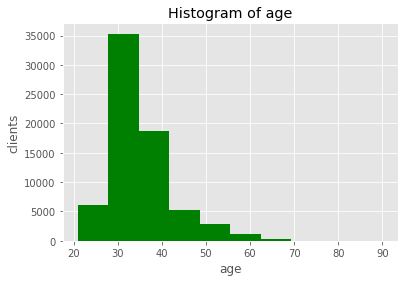

skenewss is: 1.0577519027895665


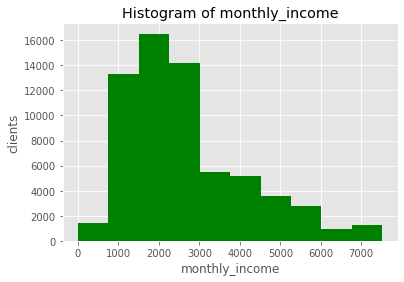

skenewss is: 2.7061862538433266


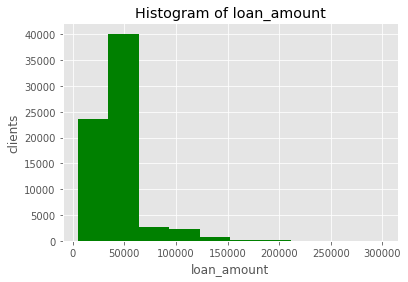

skenewss is: 2.5199960802702672


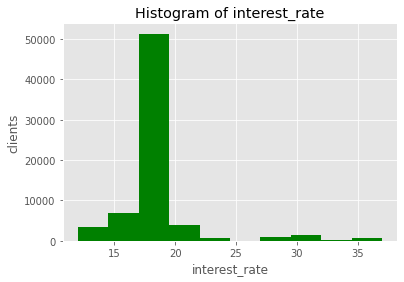

In [20]:
plot_hist(df_eda, 'age')

plot_hist(df_eda[df_eda.monthly_income < 7525], 'monthly_income') # excluding outliers

plot_hist(df_eda, 'loan_amount')

plot_hist(df_eda, 'interest_rate')

### Summary: Histograms ###
* Age: positively skewed with majority of clients with mean is around 36.
* Monthly Income: positively skewed with majority of clients monthly income is aroud 2500.
* Loan Amount: negatively skewed with majority of clients loan amount is around less than 50k.
* Interest Rate: positively skewed with majority of clients below interest rate 18%.

### Uni-variate: Bar Charts ###

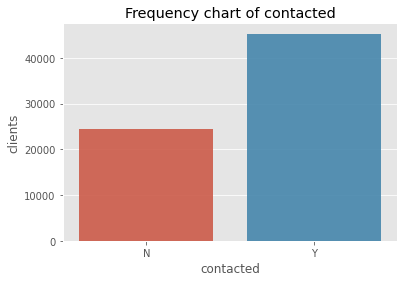

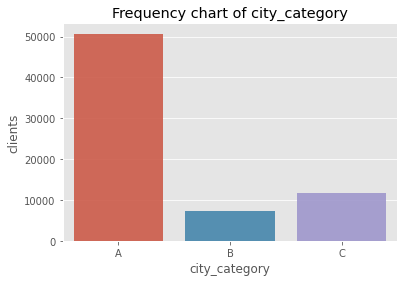

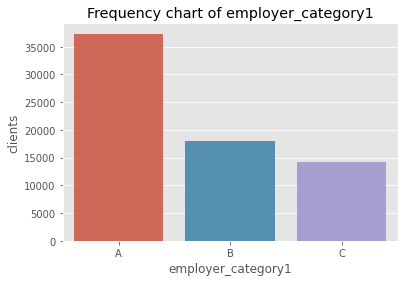

In [21]:
# plot a bar chart:
plot_bar_chart(df_eda, 'contacted')

plot_bar_chart(df_eda, 'city_category')

plot_bar_chart(df_eda, 'employer_category1')

### Summary: Bar Charts 1 ###
* Contacted: majority of clients are from contacted by a bank.
* City Category: majority of clients are from "city category" A.
* Employer Category: majority of clients are from "employer category" A.

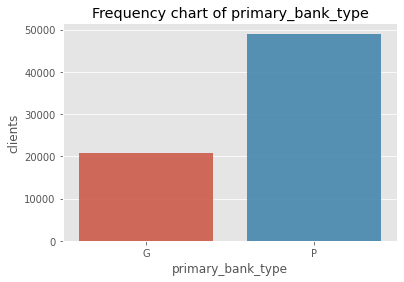

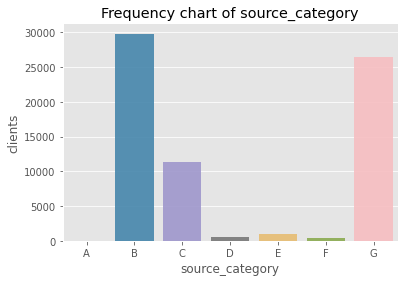

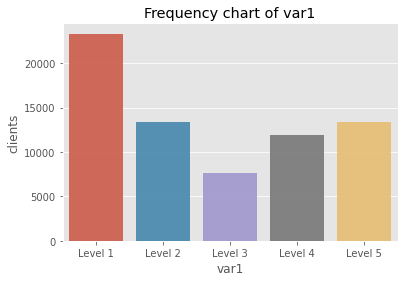

In [22]:
plot_bar_chart(df_eda, 'primary_bank_type')

plot_bar_chart(df_eda, 'source_category')

plot_bar_chart(df_eda, 'var1')

### Summary: Bar Charts 2 ###
* Primary Bank Type: majority of clients are "primary class" holders.
* Source Category: majority of clients are from "source category" from B and followed by G, C, E, D, F.
* var1: majority of clients are from "var1" from Level 1.

### Frequency Charts ###

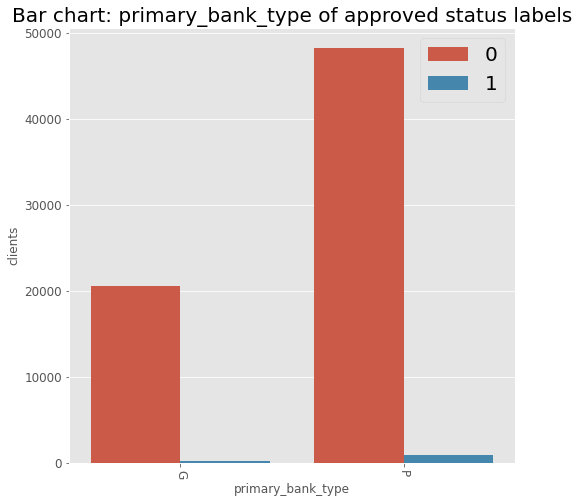

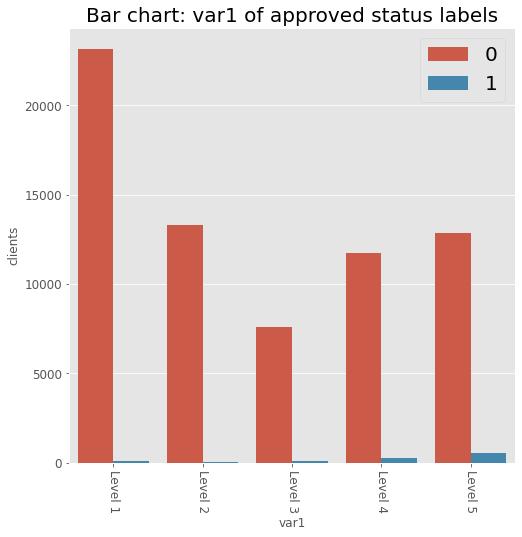

In [23]:
plot_freq_chart('primary_bank_type', 'approved', df_eda, None)

plot_freq_chart('var1', 'approved', df_eda, None)

### Summary: Frequency Chart ###
* Primary Bank Type: majority of clients from "primary" class holders.
* Var 1: majority of clients from "Level 1". 

### Uni-variate: Pie Charts ###

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:156: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


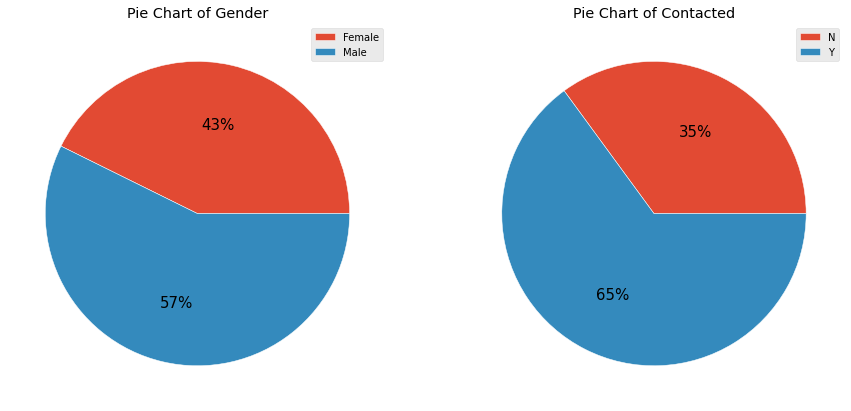

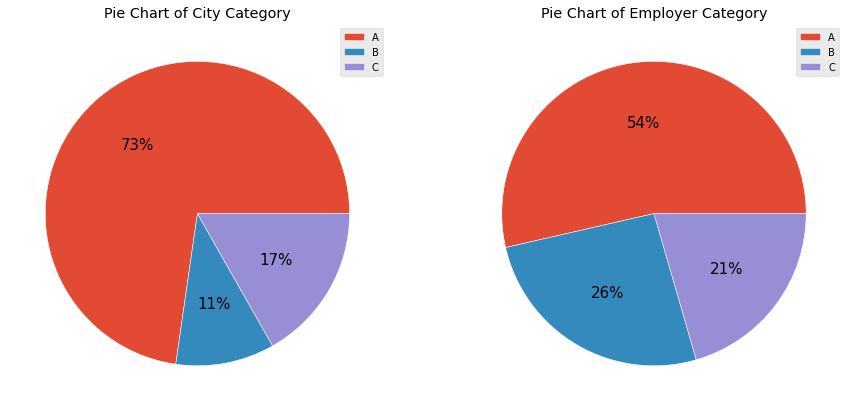

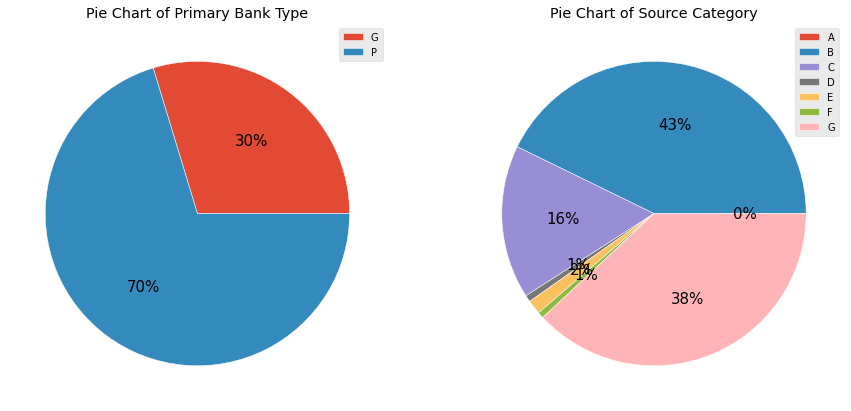

In [24]:
# grouped dataframe by a categorical feature:
df_grp_gender = eda_grouped_df_var(df_eda, 'gender')
df_grp_contacted = eda_grouped_df_var(df_eda, 'contacted')
df_grp_city_category = eda_grouped_df_var(df_eda, 'city_category')
df_grp_emp_category = eda_grouped_df_var(df_eda, 'employer_category1')
df_grp_primary_bank_type = eda_grouped_df_var(df_eda, 'primary_bank_type')
df_grp_source_category = eda_grouped_df_var(df_eda, 'source_category')
#df_grp_var1 = eda_grouped_df_var(df_eda, 'Var1')

# Plot pie chart(s) by categorical features:
plot_pie_chart(df_grp_gender, 'Gender',
               df_grp_contacted, 'Contacted')

plot_pie_chart(df_grp_city_category, 'City Category',
               df_grp_emp_category, 'Employer Category')

plot_pie_chart(df_grp_primary_bank_type, 'Primary Bank Type',
               df_grp_source_category, 'Source Category')

### Summary: Pie Chart ###
* Gender: 57 % of clients are male. 
* Contacted: 65% of clients are from contacted 
* City Category: about 73% of clients are from "A" 
* Employer Category: 54% of clients are from "A" 
* Primary Bank Type: about 70% of clients are from "Primary Class" holders.
* Source Category: 43% of clients from "A". 

### Bi-variate: Box-Whisker Plots ###

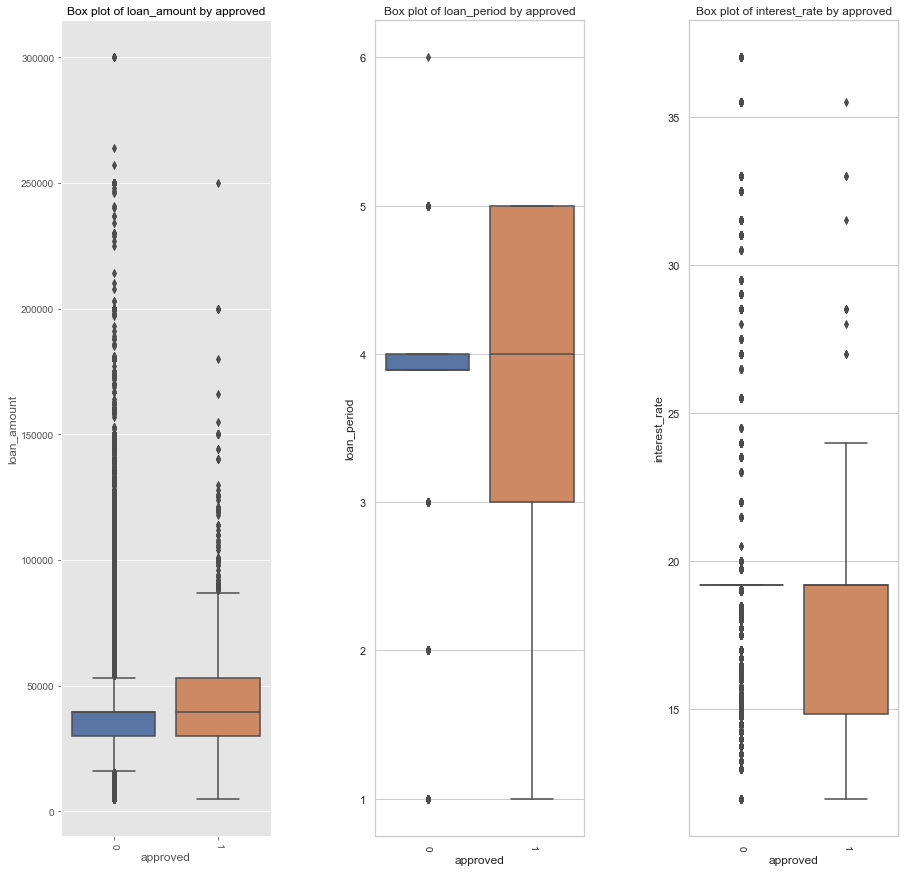

In [25]:
# plot a box-whisker:    
plot_box(df_eda, 'loan_amount', 'approved',
        'loan_period', 'approved',
        'interest_rate', 'approved')

### Summary: Box-Whisker Plot ###
* Loan amount: mean loan amount of approved client group is higher than non-approved group.
* Loan period: mean loan period of renewed client group is higher than non-approved group.
* Interest rate: non-approved group has lower than approved group.

### Bi-variate: Correlation Matrix Plot ###

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69713 entries, 64671 to 52577
Data columns (total 22 columns):
id                                     69713 non-null category
gender                                 69713 non-null category
lead_creation_date                     69713 non-null category
city_code                              69713 non-null category
city_category                          69713 non-null category
employer_code                          69713 non-null category
employer_category1                     69713 non-null category
employer_category2                     69713 non-null category
monthly_income                         69713 non-null float64
customer_existing_primary_bank_code    69713 non-null category
primary_bank_type                      69713 non-null category
contacted                              69713 non-null category
source                                 69713 non-null category
source_category                        69713 non-null category
existi

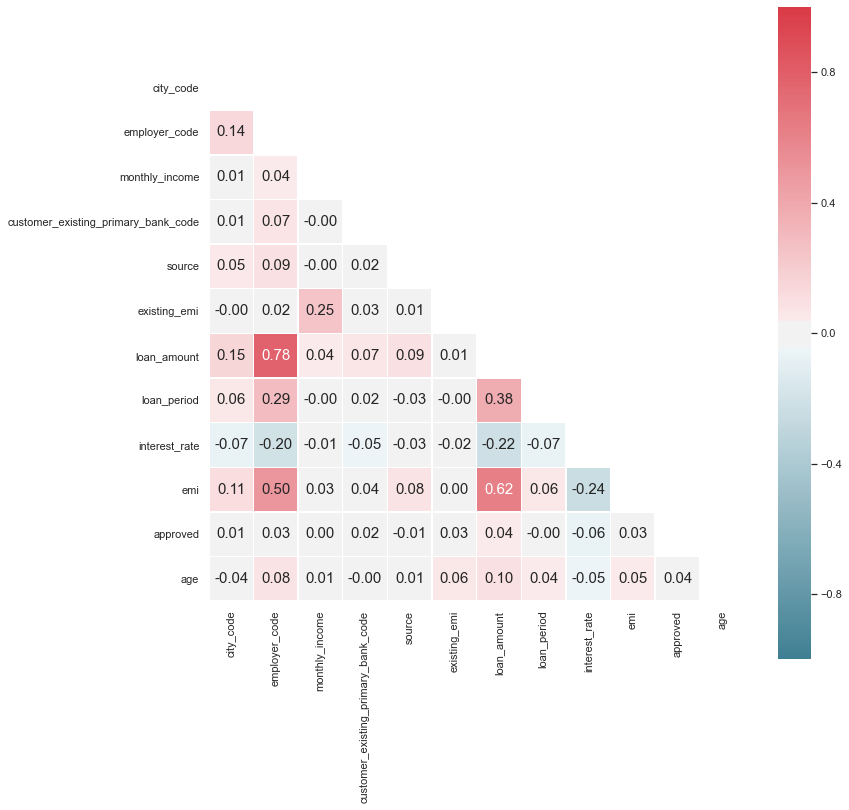

In [26]:
# create a dataframe:
df_eda_cm = df_eda.copy()

# check data type:
df_eda_cm.info()

# encode categorical variables using loan_amount:
for col in df_eda_cm.columns:
    if df_eda_cm[col].dtype.name == 'category':
        eda_encode_cat_var(df_eda_cm, col, 'loan_amount')
        
# Create a list of variables:
list_vars = list(df_eda_cm.columns)

# Delete a list of unwanted variables:
unwanted_list = {'id', 'dob', 'lead_creation_date'}

list_vars = [item for item in list_vars if item not in unwanted_list]

# plot a correlation matrix:
plot_corr_matrix(df_eda_cm, list_vars)

### Summary: Correlation Matrix Plot ###
1. Approval status shows a negative weak correlation with interest rate (r=-0.06)
2. EMI shows a positive strong correlation with loan amount (r=0.62)
3. Employer code shows a positive strong correlation with loan amount (r=0.78)
4. interest rate shows a negative weak correlation with loan amount (r=-0.22)
5. Existing EMI shows a positive weak correlation with loan amount (r=0.25)

### Bi-variate: Cross Tabulation ###

In [27]:
# plot a cross-tabulation:
plot_crosstab(df_eda, 'primary_bank_type', 'approved')

approved,0,1
primary_bank_type,,
G,20507,196
P,48186,824


In [28]:
plot_crosstab(df_eda, 'source_category', 'approved')

approved,0,1
source_category,,
A,3,0
B,29317,495
C,11234,140
D,497,0
E,1035,15
F,453,6
G,26154,364


### Summary: Cross Tabulation ###
1. approval and primary bank type: shows that general class have the lowest # of clients in both groups. Majority of clients are from "primary class".
2. approval and source category: shows that source category A have the lowest # of clients in both groups. Majority of clients are from "source category" B.

### Linear Regression Analyses ###

In [29]:
# Compute Pearson r for following:
r_ir_loan_amt= compute_pearson_r(df_eda, 'interest_rate', 'loan_amount')
print(r_ir_loan_amt)

r_emi_loan_amt = compute_pearson_r(df_eda, 'emi', 'loan_amount')
print(r_emi_loan_amt) 

r_loan_period_loan_amt = compute_pearson_r(df_eda, 'loan_period', 'loan_amount')
print(r_loan_period_loan_amt) 

-0.21767131441540097
0.6215227225291428
0.37992064773402995


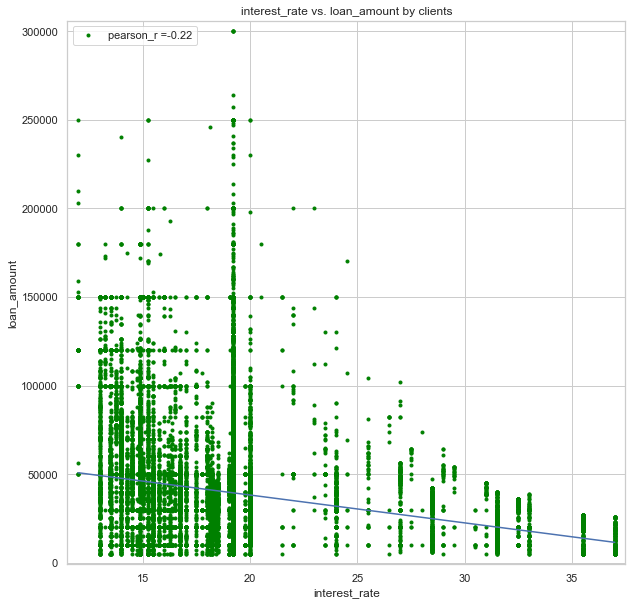

In [30]:
# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'interest_rate', 'loan_amount',
                r_ir_loan_amt, 'green', 'clients')
plt.show()

### Summary: interest rate vs. loan amount ###
There is a negatively weak correlation between interest rate and loan amount (r=-0.22). It seems that clients with higher interests have lower loan amount.

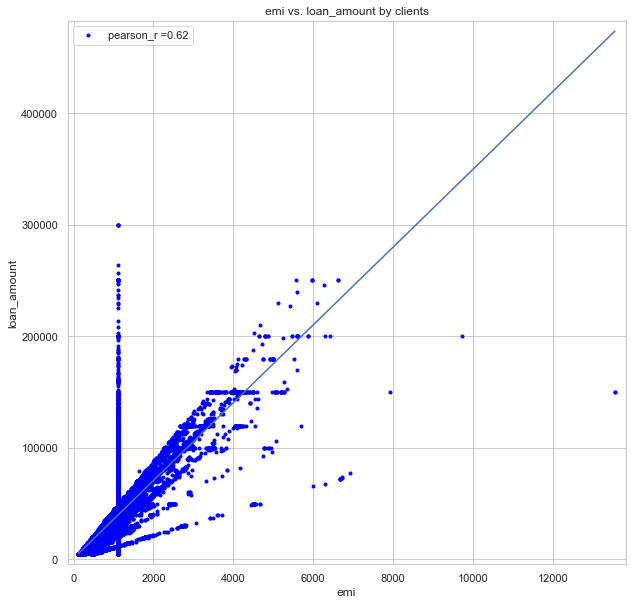

In [31]:
# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'emi', 'loan_amount',
                r_emi_loan_amt, 'blue', 'clients')
plt.show()

### Summary: emi vs. loan amount ###
There is a positively moderate correlation between emi and loan amount (r=0.62). It seems that clients with higher EMI have higher loan amount.

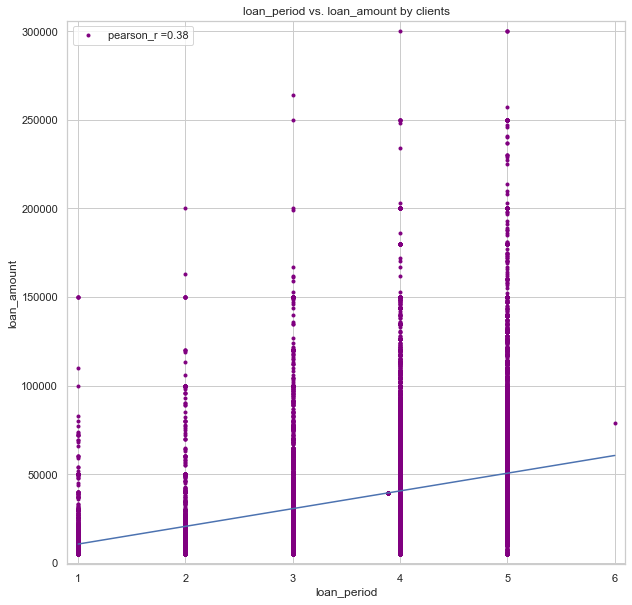

In [32]:
# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'loan_period', 'loan_amount',
                r_loan_period_loan_amt, 'purple', 'clients')
plt.show()

### Summary: loan period vs. loan amount ###
There is a positively moderate correlation between emi and loan amount (r=0.38). It seems that clients with higher loan period have higher loan amount.